# E-Commerce Customer RFM Analysis & Churn Prediction

**Author:** Aloy Sathekge  
**Purpose:** End-to-end customer analytics pipeline: RFM segmentation and churn propensity modelling for targeting and retention.

---

## Table of Contents

| # | Section | Description |
|---|---------|-------------|
| 1 | Examine the Dataset | Load data, schema, missing values, RFM column mapping |
| 2 | Data Preparation | Cleaning, deduplication, imputation |
| 3 | RFM Metrics | Define Recency, Frequency, Monetary |
| 4 | RFM Scores | Quintile-based 1–5 scoring |
| 5 | Segmentation | Rule-based segment assignment |
| 6 | Churn Prediction | Train/evaluate LR and XGBoost; business metrics |
| 7 | Conclusion | Summary and production considerations |

---

## RFM Overview

**RFM** (Recency, Frequency, Monetary) is a behaviour-based segmentation framework:

- **Recency** — Days since last order (lower = more engaged).
- **Frequency** — Number of orders (higher = more engaged).
- **Monetary** — Customer value proxy, e.g. cashback (higher = more valuable).

Customers are scored 1–5 on each dimension and grouped into segments (e.g. Champions, At Risk, Lost) for differentiated treatment and targeting.

In [11]:
# --- Standard library ---
import warnings
from pathlib import Path

# --- Third-party: data & numerics ---
import numpy as np
import pandas as pd

# --- Third-party: visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Third-party: ML ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
import xgboost as xgb

warnings.filterwarnings("ignore")

# Plotting defaults (reproducible, publication-style)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 11
sns.set_style("whitegrid")

In [ ]:
# =============================================================================
# CONFIG — Centralised constants for reproducibility and maintainability
# =============================================================================

RANDOM_STATE = 42
DATA_PATH = Path("E Commerce Dataset.xlsx")
SHEET_NAME = "E Comm"

# Data preparation
RFM_RECENCY_COL = "DaySinceLastOrder"
RFM_FREQUENCY_COL = "OrderCount"
RFM_MONETARY_COL = "CashbackAmount"
ID_COL = "CustomerID"
TARGET_COL = "Churn"

# RFM scoring
RFM_QUANTILES = 5
RFM_SCORE_MIN, RFM_SCORE_MAX = 1, 5

# Train/test split
TEST_SIZE = 0.2

# Models
LR_MAX_ITER = 1000
XGB_N_ESTIMATORS = 200
XGB_MAX_DEPTH = 4
CHURN_THRESHOLD = 0.5

---
## Helpers — Reusable functions

Encapsulating logic in functions improves testability, reuse, and clarity. All functions use type hints and docstrings.

In [ ]:
def prepare_rfm_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    One row per customer; impute RFM-related columns. Does not modify input.
    """
    data = df.drop_duplicates(subset=[ID_COL]).copy()
    data[RFM_RECENCY_COL] = data[RFM_RECENCY_COL].fillna(data[RFM_RECENCY_COL].median())
    data[RFM_FREQUENCY_COL] = data[RFM_FREQUENCY_COL].fillna(0)
    data[RFM_MONETARY_COL] = data[RFM_MONETARY_COL].fillna(data[RFM_MONETARY_COL].median())
    data = data.dropna(subset=[RFM_RECENCY_COL, RFM_FREQUENCY_COL, RFM_MONETARY_COL])
    return data


def compute_rfm_scores(data: pd.DataFrame) -> pd.DataFrame:
    """
    Add Recency, Frequency, Monetary and R_Score, F_Score, M_Score (1–5 quintiles).
    Recency: lower is better -> 5 for most recent. Frequency/Monetary: higher is better -> 5 for top.
    """
    out = data.copy()
    out["Recency"] = out[RFM_RECENCY_COL]
    out["Frequency"] = out[RFM_FREQUENCY_COL]
    out["Monetary"] = out[RFM_MONETARY_COL]
    out["R_Score"] = pd.qcut(out["Recency"], q=RFM_QUANTILES, labels=[5, 4, 3, 2, 1]).astype(int)
    out["F_Score"] = pd.qcut(out["Frequency"].rank(method="first"), q=RFM_QUANTILES, labels=[1, 2, 3, 4, 5]).astype(int)
    out["M_Score"] = pd.qcut(out["Monetary"].rank(method="first"), q=RFM_QUANTILES, labels=[1, 2, 3, 4, 5]).astype(int)
    out["RFM_Score"] = out["R_Score"].astype(str) + out["F_Score"].astype(str) + out["M_Score"].astype(str)
    return out


def assign_segment(row: pd.Series) -> str:
    """Map R, F, M scores to a named segment for targeting."""
    r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]
    total = row["Total_Score"]
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    if r <= 2 and f >= 3:
        return "At Risk"
    if r <= 2 and f <= 2 and m <= 2:
        return "Lost"
    if r <= 2 and f <= 2:
        return "Hibernating"
    if f >= 4 and m >= 4:
        return "Loyal"
    if total >= 9:
        return "Potential"
    return "Need Attention"

---
## 1. Examine the Dataset

**Objective:** Load the source data, inspect schema and missing values, and identify columns used for RFM and churn.

In [12]:
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)

print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")
print(f"\nSample (first 5 rows):")
display(df.head())

Rows: 5630, Columns: 20

Columns:
['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

First 5 rows:


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [13]:
print("Dtypes:")
print(df.dtypes)
missing = df.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print("\nMissing counts (columns with any):")
    print(missing)
else:
    print("\nNo missing values.")

print("\nRFM column mapping:")
print(f"  Recency   <- {RFM_RECENCY_COL} (days since last order; lower = better)")
print(f"  Frequency <- {RFM_FREQUENCY_COL} (order count; higher = better)")
print(f"  Monetary  <- {RFM_MONETARY_COL} (value proxy; higher = better)")
print(f"  Target    <- {TARGET_COL}")

Data types:
CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

Missing values per column:
Tenure                         264
WarehouseToHome                251
HourSpendOnApp                 255
OrderAmountHikeFromlastYear    265
CouponUsed                

---
## 2. Data Preparation

We need one row per customer with Recency, Frequency, and Monetary. We handle missing values and make sure we only use valid numbers.

In [14]:
data = prepare_rfm_data(df)

print(f"After preparation: {len(data):,} customers")
print(f"{RFM_RECENCY_COL}: min={data[RFM_RECENCY_COL].min():.0f}, max={data[RFM_RECENCY_COL].max():.0f}")
print(f"{RFM_FREQUENCY_COL}: min={data[RFM_FREQUENCY_COL].min():.0f}, max={data[RFM_FREQUENCY_COL].max():.0f}")
print(f"{RFM_MONETARY_COL}: min={data[RFM_MONETARY_COL].min():.2f}, max={data[RFM_MONETARY_COL].max():.2f}")

After preparation: 5630 customers
DaySinceLastOrder: min=0, max=46
OrderCount:         min=0, max=16
CashbackAmount:     min=0.00, max=324.99


---
## 3. RFM Metrics & Scores

**Objective:** Define Recency, Frequency, Monetary and score each customer 1–5 per dimension using quintiles.

- **Recency** = days since last order (lower = better → score 5 for most recent).
- **Frequency** = order count (higher = better → score 5 for top quintile).
- **Monetary** = cashback as value proxy (higher = better → score 5 for top quintile).

Implemented in `compute_rfm_scores()` for reuse and testability.

In [15]:
# Add RFM metrics and 1-5 scores (uses helper for consistency)
data = compute_rfm_scores(data)

print("RFM Metrics Summary:")
print(data[["Recency", "Frequency", "Monetary"]].describe().round(2))

RFM Metrics Summary:
       Recency  Frequency  Monetary
count  5630.00    5630.00   5630.00
mean      4.46       2.87    177.22
std       3.57       2.94     49.21
min       0.00       0.00      0.00
25%       2.00       1.00    145.77
50%       3.00       2.00    163.28
75%       7.00       3.00    196.39
max      46.00      16.00    324.99


---
## 4. RFM Scores

We give each customer a score from 1 to 5 for each of R, F, and M.

- **Recency**: Lower (more recent) = better → we give *low* Recency a *high* score (5). We use quintiles: bottom 20% (most recent) get 5, next 20% get 4, ... top 20% (longest since order) get 1.
- **Frequency**: Higher = better → top 20% get 5, bottom 20% get 1.
- **Monetary**: Higher = better → same as Frequency.

**Why 1–5?** It's simple to explain and to combine (e.g. 555 = best, 111 = worst). In an interview you can say: "We score each dimension 1–5 using quintiles, then segment by combinations of scores."

In [8]:
# Scores computed in Section 3 via compute_rfm_scores(). Summary:
print("Score distribution (1-5 per dimension):")
print(data[["R_Score", "F_Score", "M_Score"]].describe())
print("\nSample (first 5 customers):")
display(data[[ID_COL, "R_Score", "F_Score", "M_Score", "RFM_Score"]].head())

Score distribution:
           R_Score      F_Score      M_Score
count  5630.000000  5630.000000  5630.000000
mean      3.383126     3.000000     3.000000
std       1.482449     1.414339     1.414339
min       1.000000     1.000000     1.000000
25%       2.000000     2.000000     2.000000
50%       4.000000     3.000000     3.000000
75%       5.000000     4.000000     4.000000
max       5.000000     5.000000     5.000000

Example: first 5 customers R, F, M scores:
   CustomerID  R_Score  F_Score  M_Score RFM_Score
0       50001        2        1        3       213
1       50002        5        1        1       511
2       50003        4        1        1       411
3       50004        4        1        1       411
4       50005        4        1        1       411


---
## 5. Segmentation

We group customers into segments based on their R, F, M scores. Common naming:

| Segment      | Typical R,F,M | Meaning |
|-------------|----------------|--------|
| Champions   | High R, F, M   | Best customers: recent, frequent, high value. Reward them. |
| Loyal       | High F, M      | Buy often and spend well. Keep them engaged. |
| At Risk     | Low R, high F,M| Used to be good, haven't bought recently. Win them back. |
| Hibernating | Low R, low F    | Rarely buy and not recent. Re-activate or accept low priority. |
| Lost        | Low R, F, M    | Gone. Low priority for expensive campaigns. |

We use simple rules: total score (R+F+M) and/or individual thresholds to assign each customer to a segment.

In [9]:
data["Total_Score"] = data["R_Score"] + data["F_Score"] + data["M_Score"]
data["Segment"] = data.apply(assign_segment, axis=1)

print("Segment counts:")
print(data["Segment"].value_counts().sort_values(ascending=False))

Segment counts:
Segment
Potential         1981
At Risk           1515
Need Attention    1085
Champions          410
Hibernating        387
Lost               188
Loyal               64
Name: count, dtype: int64


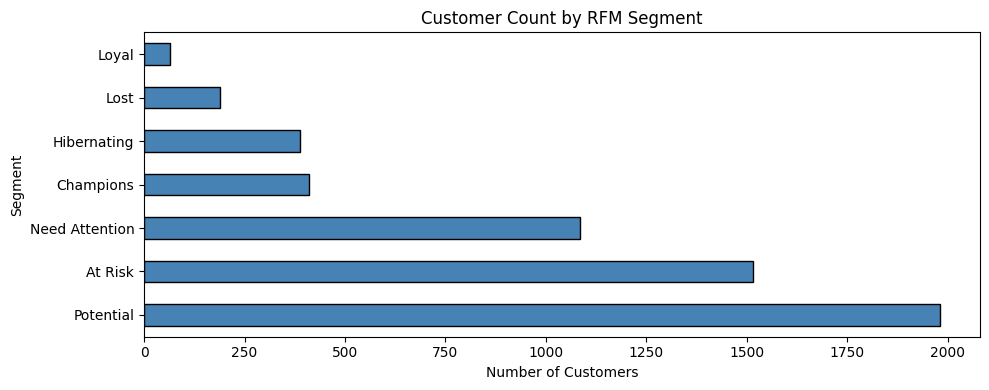


Average R, F, M by segment:
                Customers  Avg_Recency  Avg_Frequency  Avg_Monetary
Segment                                                            
At Risk              1515         8.46           5.48        193.17
Champions             410         2.51           5.03        221.73
Hibernating           387         8.58           0.64        215.65
Lost                  188         7.59           1.09        138.63
Loyal                  64         4.00           4.34        211.74
Need Attention       1085         1.85           1.15        132.21
Potential            1981         2.14           1.93        175.51


In [10]:
# Plot segment sizes
seg_counts = data["Segment"].value_counts()
plt.figure(figsize=(10, 4))
seg_counts.plot(kind="barh", color="steelblue", edgecolor="black")
plt.title("Customer Count by RFM Segment")
plt.xlabel("Number of Customers")
plt.tight_layout()
plt.show()

# Compare average Recency, Frequency, Monetary by segment
segment_metrics = data.groupby("Segment").agg(
    Customers=(ID_COL, "count"),
    Avg_Recency=("Recency", "mean"),
    Avg_Frequency=("Frequency", "mean"),
    Avg_Monetary=("Monetary", "mean"),
).round(2)
print("\nAverage R, F, M by segment:")
print(segment_metrics)

---
## 6. Churn Prediction Model

We use the same dataset and RFM segments to **predict who will churn**. The target is the existing **Churn** column (1 = churned, 0 = stayed). We use RFM scores plus other behaviour features (tenure, satisfaction, complaints, etc.) to train a model. This gives each customer a **churn probability** we can use for targeting (e.g. offer retention to high-risk customers).

In [ ]:
# Require RFM and Segment (run Sections 1-5 first)
model_df = data.dropna(subset=[TARGET_COL]).copy()
y = model_df[TARGET_COL]
X = model_df.drop(columns=[ID_COL, TARGET_COL])

# Fill numeric missing with median
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Fill categorical missing with "Unknown"
cat_cols = X.select_dtypes(include=["object"]).columns
for c in cat_cols:
    X[c] = X[c].fillna("Unknown")

# Convert categories to 0/1 columns (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Remove any row that still has NaN (e.g. from new categories)
mask = X.isnull().any(axis=1)
X = X[~mask]
y = y[~mask]

# Split: 80% train, 20% test, keep same churn rate in both
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"Training: {len(X_train):,} | Test: {len(X_test):,}")
print(f"Churn rate — train: {y_train.mean():.1%} | test: {y_test.mean():.1%}")
print(f"Features: {X.shape[1]}")

In [ ]:
# Model 1: Logistic Regression (interpretable baseline; class_weight for imbalance)
lr = LogisticRegression(class_weight="balanced", max_iter=LR_MAX_ITER, random_state=RANDOM_STATE)
lr.fit(X_train_s, y_train)
lr_proba = lr.predict_proba(X_test_s)[:, 1]
lr_pred = (lr_proba >= CHURN_THRESHOLD).astype(int)
lr_auc = roc_auc_score(y_test, lr_proba)

# Model 2: XGBoost (scale_pos_weight for imbalance)
imbalance = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
xgb_model = xgb.XGBClassifier(
    n_estimators=XGB_N_ESTIMATORS,
    max_depth=XGB_MAX_DEPTH,
    scale_pos_weight=imbalance,
    random_state=RANDOM_STATE,
    eval_metric="auc",
)
xgb_model.fit(X_train_s, y_train)
xgb_proba = xgb_model.predict_proba(X_test_s)[:, 1]
xgb_pred = (xgb_proba >= CHURN_THRESHOLD).astype(int)
xgb_auc = roc_auc_score(y_test, xgb_proba)

print("Logistic Regression — Test AUC:", round(lr_auc, 3))
print(classification_report(y_test, lr_pred, target_names=["Stayed", "Churned"]))

print("\nXGBoost — Test AUC:", round(xgb_auc, 3))
print(classification_report(y_test, xgb_pred, target_names=["Stayed", "Churned"]))

print("Confusion matrix (XGBoost):")
print(confusion_matrix(y_test, xgb_pred))

In [ ]:
# ROC curve: how well the model ranks churners vs non-churners
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test_s)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_s)[:, 1])

plt.figure(figsize=(8, 5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={lr_auc:.3f})", lw=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={xgb_auc:.3f})", lw=2)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Churn Prediction — ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Churn rate by RFM segment — do our segments match who actually churned?
churn_by_segment = data.groupby("Segment").agg(
    Customers=(ID_COL, "count"),
    ChurnRate=(TARGET_COL, "mean"),
).round(3)
churn_by_segment = churn_by_segment.sort_values("ChurnRate", ascending=False)

print("Actual churn rate by RFM segment:")
print(churn_by_segment)

# "At Risk" and "Lost" should have higher churn; "Champions" lower
churn_by_segment["ChurnRate"].plot(kind="barh", figsize=(8, 4), color="coral", edgecolor="black")
plt.title("Churn Rate by RFM Segment")
plt.xlabel("Churn Rate")
plt.tight_layout()
plt.show()

---
## 7. Conclusion

**What we did**
1. **Examined** the e-commerce dataset: columns, missing values, and which fields to use for RFM.
2. **Prepared** the data: one row per customer, filled missing values for DaySinceLastOrder, OrderCount, CashbackAmount.
3. **Computed RFM**: Recency (days since last order), Frequency (order count), Monetary (cashback as value proxy).
4. **Scored** each customer 1–5 on R, F, and M using quintiles (so each score has ~20% of customers).
5. **Segmented** customers into Champions, Loyal, At Risk, Hibernating, Lost, Potential, Need Attention using simple rules on R, F, M.
6. **Churn prediction**: trained Logistic Regression and XGBoost on RFM + behaviour features; evaluated with AUC-ROC and showed churn rate by segment.

**Interview takeaways**
- **RFM** is a behaviour-based segmentation that doesn’t need ML: just rules and quintiles.
- **Recency** is often the strongest signal: “when did they last buy?” matters a lot for churn and reactivation.
- **Segmentation** drives action: different segments get different treatments (rewards vs win-back vs low-touch).
- **Churn model** gives a probability per customer; combine with **RFM value** for targeting (e.g. high risk + high value = priority retention).

**Reproducibility & production**
- All randomness controlled by `RANDOM_STATE`. Config (paths, split, model params) is in one cell.
- In production: retrain on a schedule, monitor AUC/drift, validate incremental impact via holdout control groups.